In [20]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator
from qiskit import transpile

import pylatexenc

# for testing
from random import randint

import numpy as np
# make numpy output look better
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")

# Five Qubit Error-Correcting Code

## Stabilizer Group

We follow Nielsen and Chuang's [Quantum Computation and Quantum Information](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview), Section 10.5.6.

Generators of the stabilizer group:

$$
  \begin{align*}
    g_1 &= X \otimes Z \otimes Z \otimes X \otimes \mathbb{I}. \\
    g_2 &= \mathbb{I} \otimes X \otimes Z \otimes Z \otimes X ,\\
    g_3 &= X \otimes \mathbb{I} \otimes X \otimes Z \otimes Z ,\\
    g_4 &= Z \otimes X \otimes \mathbb{I} \otimes X \otimes Z, \\
  \end{align*}
$$

In [22]:
g_gates = {
    1: ["x", "i", "x", "z", "z"],
    2: ["z", "x", "i", "x", "z"],
    3: ["x", "z", "z", "x", "i"],
    4: ["i", "x", "z", "z", "x"],
}

In [25]:
g = {}

for i, gates in g_gates.items():
    quantum_register = QuantumRegister(size=len(gates), name="x")
    circuit = QuantumCircuit(quantum_register)
    for j, gate in enumerate(gates):
        if gate == "x":
            circuit.x(j)
        elif gate == "z":
            circuit.z(j)
    g[i] = circuit

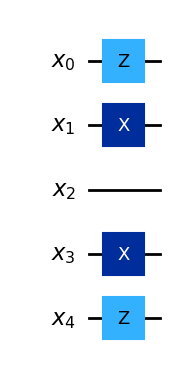

In [27]:
i = 2
g[i].draw("mpl")

## Encoding

We follow the circuit provided in Chandak, Mardia, and Tolunay's [Implementation and analysis of stabilizer codes in pyQuil](https://shubhamchandak94.github.io/reports/stabilizer_code_report.pdf)

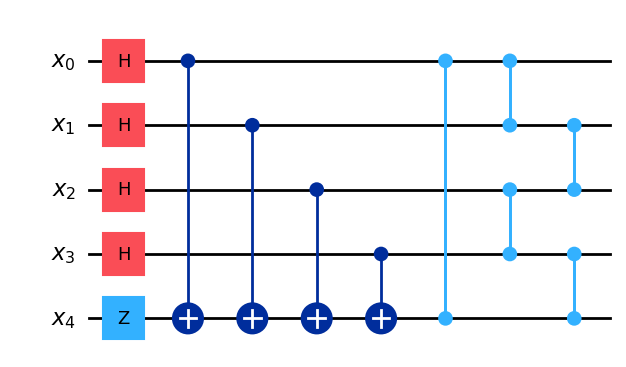

In [4]:
quantum_register = QuantumRegister(size=5, name="x")
encoder_circ = QuantumCircuit(quantum_register)

encoder_circ.h(quantum_register[:-1])
encoder_circ.z(-1)
for i in range(4):
    encoder_circ.cx(i, 4)
encoder_circ.cz(0, 4)
for i in range(0, 4, 2):
    encoder_circ.cz(i, i + 1)
for i in range(1, 5, 2):
    encoder_circ.cz(i, i + 1)

encoder_circ.draw("mpl")

In [5]:
logical_0 = Statevector(encoder_circ)

Let's check that the coefficients are what we expect.  They should all be real:

In [6]:
for x in logical_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should all be $0$ or $\pm 1/4$:

In [7]:
a = np.abs(4 * logical_0.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

True

In [8]:
def binary_digits(a, n):
    """
    Given a and n, returns the first n digits of the binary representation of a.

    INPUTS:
    * a: A positive integer;
    * n: the number of binary digits.

    OUTPUT:
    An array of length n containing the first n binary digits of a, from letft to right.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


for i, coef in enumerate(4 * logical_0.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

  1: [0 0 0 0 0]
 -1: [1 1 0 0 0]
  1: [1 0 1 0 0]
 -1: [0 1 1 0 0]
  1: [1 0 0 1 0]
  1: [0 1 0 1 0]
 -1: [0 0 1 1 0]
 -1: [1 1 1 1 0]
 -1: [1 0 0 0 1]
  1: [0 1 0 0 1]
  1: [0 0 1 0 1]
 -1: [1 1 1 0 1]
 -1: [0 0 0 1 1]
 -1: [1 1 0 1 1]
 -1: [1 0 1 1 1]
 -1: [0 1 1 1 1]


To encode $\left| 1_L \right\rangle$ we need to use $\left| 0 \right\rangle^{\otimes 4} \left| 0 \right\rangle$ as input:

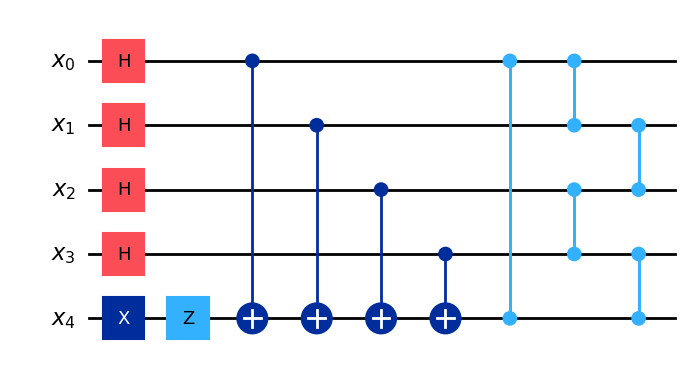

In [9]:
quantum_register = QuantumRegister(size=5, name="x")
circ = QuantumCircuit(quantum_register)

circ.x(-1)
circ.compose(encoder_circ, inplace=True)

circ.draw("mpl")

In [10]:
logical_1 = Statevector(circ)

Let's check that the coefficients are what we expect.  They should all be real:

In [11]:
for x in logical_1.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should all be $0$ or $\pm 1/4$:

In [12]:
a = np.abs(4 * logical_1.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

True

In [13]:
for i, coef in enumerate(4 * logical_1.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

 -1: [1 0 0 0 0]
 -1: [0 1 0 0 0]
 -1: [0 0 1 0 0]
 -1: [1 1 1 0 0]
 -1: [0 0 0 1 0]
  1: [1 1 0 1 0]
  1: [1 0 1 1 0]
 -1: [0 1 1 1 0]
 -1: [0 0 0 0 1]
 -1: [1 1 0 0 1]
  1: [1 0 1 0 1]
  1: [0 1 1 0 1]
 -1: [1 0 0 1 1]
  1: [0 1 0 1 1]
 -1: [0 0 1 1 1]
  1: [1 1 1 1 1]


Let's test against the $g_i$'s:

In [19]:
quantum_register_1 = QuantumRegister(size=5, name="x")
set_1 = QuantumCircuit(quantum_register_1)
set_1.x(-1)

for i, gi in g.items():
    output_0 = Statevector(encoder_circ.compose(gi))
    output_1 = Statevector(set_1.compose(encoder_circ.compose(gi)))

    cond = np.array_equal(output_0.data, logical_0.data) and np.array_equal(output_1, logical_1.data)

    if not cond:
        print("Failed!")
        break
else:
    print("It worked!")

It worked!


## Error Correction

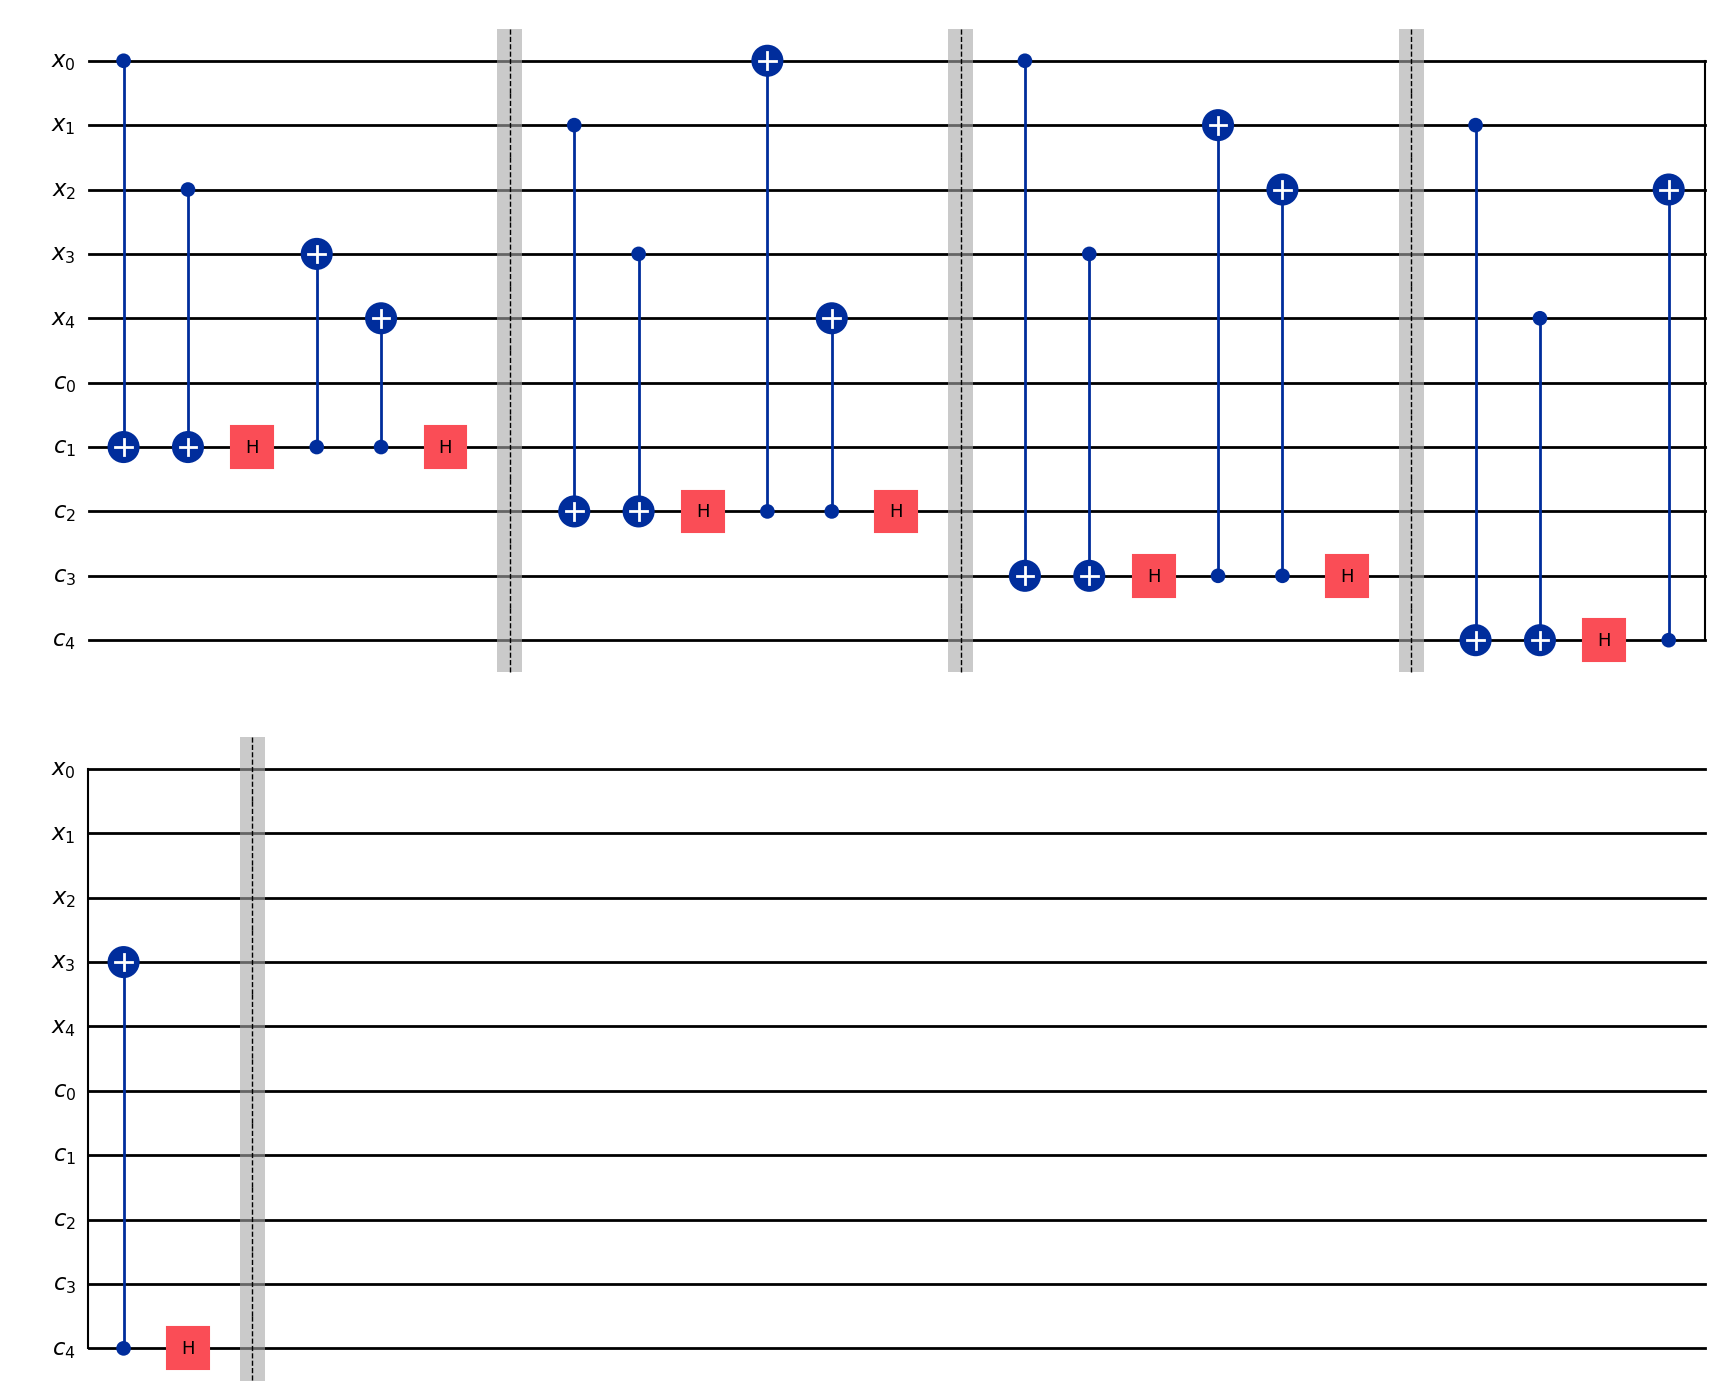

In [28]:
register_size = len(g[0][1])
checks_size = len(g)

quantum_register = QuantumRegister(size=register_size, name="x")
checks_register = QuantumRegister(size=checks_size, name="c")

code_circuit = QuantumCircuit(quantum_register, checks_register)

for i, gates in g_gates.items():
    for j, gate in enumerate(gates):
        if gate == "x":
            code_circuit.cx(j, i + )
    if "z" in gates:
        code_circuit.h(i + 5)
        for j, gate in enumerate(gates):
            if gate == "z":
                code_circuit.cx(i + 5, j)
        code_circuit.h(i + 5)
    code_circuit.barrier()

code_circuit.draw("mpl")

In [ ]:
syndromes = ClassicalRegister(size=5, name="s")

code_circuit.add_register(syndromes)